# Final Presentation ACDC

In this notebook we will walk through examples of this package. The package consists of a class for graph processing, a class for processing the power system and a class to simulate the power system, which were made in the three assignments. The first two parts are individual modules. The third part uses the first and second module. They cover the following points:

Graph processing:
- Find downstream vertices.
- Find alternative edges.

Power grid model:
- Handle PGM input format.
- Aggregate the power flow results in tables.
- Show tables with data of powerflow calculations.

Power system simulation:
- Calculate EV penetration levels.
- Calculate optimal tap positions.
- Do N-1 calculations.

All:
- Raise errors if the data input is incorrect.

The package uses the following libraries:
- Power Grid Model
- Pandas
- Numpy
- SciPy
- Math
- Random
- Enum

In [1]:
# some basic imports
import pytest
import graph_processing as tp  # Import power_system_simpulation.graphy_processing
import pandas as pd
import numpy as np
import scipy as sp

import power_flow_processing as pfp
from graph_processing import (
    EdgePairNotUniqueError,
    GraphCycleError,
    GraphNotFullyConnectedError,
    GraphProcessor,
    IDNotFoundError,
    IDNotUniqueError,
    InputLengthDoesNotMatchError,
)

# 1.1 Input dataset

We create an input graph by using the following parameters: 
- `vertex_ids`
- `edge_ids`
- `edge_vertex_id_pairs`
- `edge_enabled`
- `source_vertex_id`

In [2]:
vertex_ids = [0, 2, 4, 6, 10]  # All unique vertex ids
edge_ids = [1, 3, 5, 7, 8, 9]  # All unique edge ids
edge_vertex_id_pairs = [  # Which vertex ids are connected by an edge
    (0, 2),  # edge 1
    (0, 4),  # edge 3
    (0, 6),  # edge 5
    (2, 4),  # edge 7
    (4, 6),  # edge 8
    (2, 10),  # edge 9
]
edge_enabled = [True, True, True, False, False, True]  # Whether each edge is enabled or disabled
source_vertex_id = 0  # ID of the source vertex

This graph will result in this visual representation: 

In [3]:
# vertex_0 (source) --edge_1(enabled)-- vertex_2 --edge_9(enabled)-- vertex_10
#                  |                               |
#                  |                           edge_7(disabled)
#                  |                               |
#                  -----------edge_3(enabled)-- vertex_4
#                  |                               |
#                  |                           edge_8(disabled)
#                  |                               |
#                  -----------edge_5(enabled)-- vertex_6

# 1.2 Validation
This graph is tested for the following conditions: 
1. `vertex_ids` and `edge_ids` should be unique.
    - This function compares the length of all `vertex_ids` to the set of `vertex_ids` and gives an error if they are not the same. It uses the same approach for `edge_ids`.
2. `edge_vertex_id_pairs` should have the same length as `edge_ids`.
    - This function compares the length of the list of `edge_vertex_id_pairs` and `edge_ids`.
3. `edge_vertex_id_pairs` should contain valid `vertex ids`.
    - Using a loop all `edge_vertex_id_pairs` are checked to also be valid `edge_ids`.
4. `edge_enabled` should have the same length as `edge_ids`.
    - The length of the `edge_enabled` list is compared to length of the `edge_ids` list. 
5. `source_vertex_id` should be a valid `vertex_ids`.
     - The `source_vertex_id` is checked to be part of `vertex_ids`.
6. The graph should not contain cycles.
    - An adjacency list is built and using depth first search cycles are detected. 
7. The graph should be fully connected.
    - Using depth first search the length of all the visited vertex and the length of `vertex_ids` is compared. 
8. Multiple edges should not connect the same two `vertex_ids`. 
    - A list of `edge_vertex_id_pairs` is compared to a list of the set of `edge_vertex_id_pairs`.

This can be tested by calling the `tp.GraphProcessor` function: 

In [4]:
test2 = tp.GraphProcessor(
    vertex_ids=vertex_ids,
    edge_ids=edge_ids,
    edge_vertex_id_pairs=edge_vertex_id_pairs,
    edge_enabled=edge_enabled,
    source_vertex_id=source_vertex_id,
)

# Example
When for example not all `vertex_ids` are unique the following error will be raised: 

In [5]:
try:
    GraphProcessor([1, 2, 3, 3, 5], [1, 2, 3], [(1, 2), (2, 3), (1, 5)], [True, True, True], 1)
except IDNotUniqueError as e:
    print(e)

Vertex IDs are not unique


In [6]:
test = tp.GraphProcessor(
    vertex_ids=vertex_ids,
    edge_ids=edge_ids,
    edge_vertex_id_pairs=edge_vertex_id_pairs,
    edge_enabled=edge_enabled,
    source_vertex_id=source_vertex_id,
)

# 1.3 Find downstream vertices

 Given an `edge_id`, return all the vertices which are in the downstream of the edge, with respect to the source vertex. Including the downstream vertex of the edge itself!
 Only the `edge_enabled` are taken into account. 
 The function returns a list of all downstream `vertex_ids`. 

In [7]:
vertex_ids = [0, 2, 4]  # All unique vertex ids
edge_ids = [1, 3]  # All unique edge ids
edge_vertex_id_pairs = [(0, 2), (2, 4)]  # Egde 1 and egde 3
edge_enabled = [True, True]  # Whether each edge is enabled or disabled
source_vertex_id = 0  # ID of the source vertex

test3 = tp.GraphProcessor(
    vertex_ids=vertex_ids,
    edge_ids=edge_ids,
    edge_vertex_id_pairs=edge_vertex_id_pairs,
    edge_enabled=edge_enabled,
    source_vertex_id=source_vertex_id,
)

downstream_vertices = test3.find_downstream_vertices(1)
print(downstream_vertices)

[2, 4]


# 1.4 Find alternative edges 
Given an enabled edge the following analysis is done: 
- If this edge is going to be disabled. 
- Which (currently disabled) edge can be enabled to ensure that the graph is again fully connected and acyclic?
- Return a list of all alternative edges.

Our example graph would return the following results:   
        Call find_alternative_edges with disabled_edge_id=1 will return [7]   
        Call find_alternative_edges with disabled_edge_id=3 will return [7, 8]   
        Call find_alternative_edges with disabled_edge_id=5 will return [8]   
        Call find_alternative_edges with disabled_edge_id=9 will return []   

This function can be used by using the `find_alternative_edges` function and giving an `edge_ids` as input. 

In [8]:
alternative_edges = test2.find_alternative_edges(1)
print("Alternative edge when disabling edge 1 is:", alternative_edges)

alternative_edges = test2.find_alternative_edges(3)
print("Alternative edge when disabling edge 3 are:", alternative_edges)

alternative_edges = test2.find_alternative_edges(5)
print("Alternative edge when disabling edge 5 are:", alternative_edges)

alternative_edges = test2.find_alternative_edges(9)
print("Alternative edge when disabling edge 9 are:", alternative_edges)

Alternative edge when disabling edge 1 is: [7]
Alternative edge when disabling edge 3 are: [7, 8]
Alternative edge when disabling edge 5 are: [8]
Alternative edge when disabling edge 9 are: []


### How does the alternative edge function work?

1. The user specifies an edge which is going to be disabled
2. The function validates whether the specified edge ID exists and if it is not already disabled
3. The function iterates through all edges, checking if they are disabled or not
4. Once a disabled edge is found, it is enabled
5. For this edge, an adjacency list with enabled edges is built using another function
6. This adjacency list is used as input to the Depth-First-Search (DFS) function which checks for connectivity and cycles
7. If the DFS function returns an acyclic and fully connected network, the edge is added to the alternative edges list

# Graph plotting
Additionally, the graph can be plotted by calling `tp.graph_plotter()`.

Figure(1000x1000)


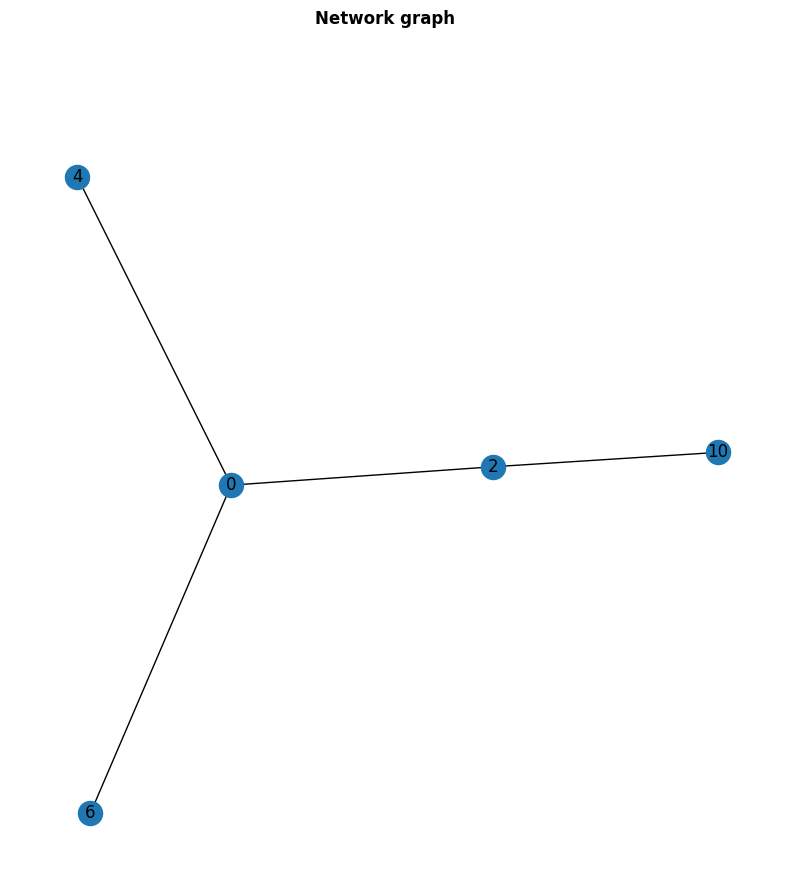

In [9]:
test.graph_plotter()

Figure(1000x1000)


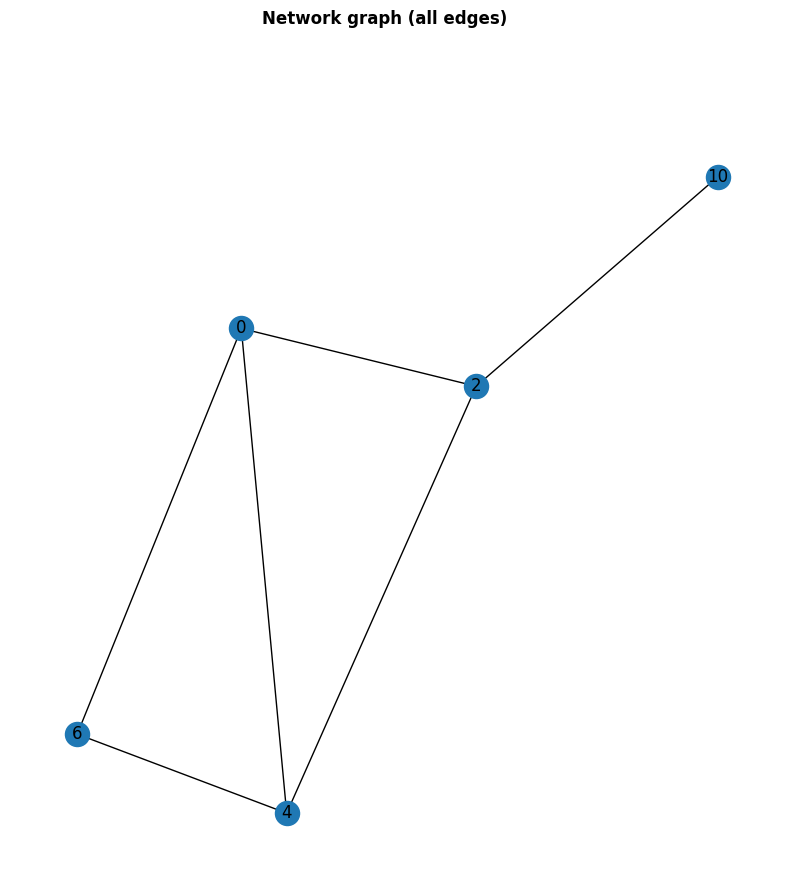

In [10]:
test.graph_plotter(tp.AllEdges)

# 2.1 Power Grid Model (PGM) Input

The following sections describe a power grid calculation module with the use of the `power-grid-model` library. Firstly, we must handle the following inputs:
- A power grid in PGM format
- A table containing active load profile of all the `sym_load` in the grid, with timestamps and load ids.
- A table containing ractive load profile of all the `sym_load` in the grid, with timestamps and load ids.

This data can be imported using the following code:

In [11]:
from power_grid_model.utils import json_deserialize_from_file

grid_data = json_deserialize_from_file("input_network_data_big.json")
active_power_profile = pd.read_parquet("active_power_profile_big.parquet")
reactive_power_profile = pd.read_parquet("reactive_power_profile_big.parquet")

The `grid_data` consists of several different tables containing information about different elements of the grid, like lines, nodes, sources and load information.

In [12]:
display(pd.DataFrame(grid_data["line"]))
display(pd.DataFrame(grid_data["node"]))
display(pd.DataFrame(grid_data["source"]))
display(pd.DataFrame(grid_data["sym_load"]))

,id,from_node,to_node,from_status,to_status,r1,x1,c1,tan1,r0,x0,c0,tan0,i_n
0,1204,1,2,1,1,0.001240,0.000563,5.627780e-09,0.003,0.004486,0.001550,3.344043e-09,0.001,1794.364707
1,1205,2,3,1,1,0.005110,0.000711,5.186721e-09,0.003,0.017289,0.002017,3.073612e-09,0.001,960.503800
2,1206,2,4,1,1,0.001321,0.000600,5.995138e-09,0.003,0.004779,0.001651,3.562328e-09,0.001,1911.493314
3,1207,4,5,1,1,0.006234,0.000867,6.327269e-09,0.003,0.021091,0.002461,3.749493e-09,0.001,1171.716567
4,1208,4,6,1,1,0.001266,0.000575,5.746902e-09,0.003,0.004581,0.001582,3.414826e-09,0.001,1832.345417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802,2006,300,400,1,0,0.001171,0.000532,5.317533e-09,0.003,0.004239,0.001464,3.159693e-09,0.001,1695.445247
803,2007,400,500,1,0,0.001156,0.000525,5.249314e-09,0.003,0.004184,0.001445,3.119157e-09,0.001,1673.694227
804,2008,500,600,1,0,0.001366,0.000620,6.203078e-09,0.003,0.004944,0.001708,3.685887e-09,0.001,1977.792940
805,2009,600,700,1,0,0.001318,0.000598,5.981550e-09,0.003,0.004768,0.001647,3.554255e-09,0.001,1907.160964


,id,u_rated
0,0,10500.0
1,1,400.0
2,2,400.0
3,3,400.0
4,4,400.0
...,...,...
797,797,400.0
798,798,400.0
799,799,400.0
800,800,400.0


,id,node,status,u_ref,u_ref_angle,sk,rx_ratio,z01_ratio
0,802,0,1,1.05,NaN,200000000.0,NaN,NaN


,id,node,status,type,p_specified,q_specified
0,804,3,1,0,0.0,0.0
1,805,5,1,0,0.0,0.0
2,806,7,1,0,0.0,0.0
3,807,9,1,0,0.0,0.0
4,808,11,1,0,0.0,0.0
...,...,...,...,...,...,...
395,1199,793,1,0,0.0,0.0
396,1200,795,1,0,0.0,0.0
397,1201,797,1,0,0.0,0.0
398,1202,799,1,0,0.0,0.0


The `active_power_profile` and `reactive_power_profile` contain the power profiles for different loads, so they tell how much power should be supplied to for example a household or factory (loads) at what time.

In [13]:
display(active_power_profile)
display(reactive_power_profile)

Load ID,804,805,806,807,808,809,810,811,812,813,...,1194,1195,1196,1197,1198,1199,1200,1201,1202,1203
Timestamp,,,,,,,,,,,,,,,,,,,,,
2025-01-01 00:00:00,-48.645687,200.196638,454.732665,732.395596,267.499176,611.717032,254.338734,317.932792,262.726267,618.102118,...,1179.125131,301.604449,426.131790,-619.337022,151.608512,260.930791,555.864018,-464.556040,-223.681091,92.390827
2025-01-01 00:15:00,459.401364,86.614127,854.149162,465.688114,615.002203,627.578955,37.474129,-166.189624,521.038548,114.571584,...,369.539329,401.292167,199.061035,-454.041658,1104.717937,14.379155,617.407629,1297.579636,210.676827,131.198413
2025-01-01 00:30:00,478.423831,202.095618,-86.316669,252.347085,-113.888404,265.090327,108.922155,286.220995,-553.778850,45.005134,...,-193.883723,-240.421330,305.903654,928.935043,527.033226,144.213458,695.340310,783.227006,778.901533,289.816463
2025-01-01 00:45:00,210.018959,71.134492,538.150366,44.299531,89.029379,450.290585,565.515555,95.439486,329.746386,-92.267910,...,-291.881918,616.512688,382.101649,442.723700,-75.768118,88.581603,543.475515,457.304274,630.077828,356.926533
2025-01-01 01:00:00,62.196078,-92.797060,366.733801,178.153098,448.555839,172.148972,291.516223,439.438873,40.244733,346.311039,...,379.825460,554.151365,200.048591,-52.935004,-192.879871,-209.468020,625.399327,647.996009,65.281115,426.552745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-31 22:45:00,-628.731824,-944.237036,1570.548071,1947.270828,-271.645780,450.002728,145.282273,-1239.175982,3101.065482,2549.258325,...,1438.103593,-923.277000,2419.155295,1598.251748,-30.165536,3415.892221,-631.551619,1299.900014,-850.655992,2092.283108
2025-12-31 23:00:00,1248.414212,-160.195433,1486.673421,818.369106,118.726265,2250.568452,1986.093572,513.901101,598.344844,2012.412914,...,769.679070,328.375470,1557.217839,3178.955632,2250.550887,1581.003487,3182.131078,732.059770,334.416169,2316.463915
2025-12-31 23:15:00,1067.535322,2664.881737,-78.811133,895.144175,789.772237,-18.149492,1114.511952,1685.429124,808.155447,828.255408,...,1736.590261,1294.499940,746.334638,-234.981949,713.176398,-644.496728,2910.781477,192.561791,1405.037568,396.179499


Load ID,804,805,806,807,808,809,810,811,812,813,...,1194,1195,1196,1197,1198,1199,1200,1201,1202,1203
Timestamp,,,,,,,,,,,,,,,,,,,,,
2025-01-01 00:00:00,4.734802,52.317783,80.700427,-68.643412,21.394314,-85.020953,62.597494,-81.002268,-49.664857,-128.790129,...,-165.320032,-95.273859,-28.230379,77.954485,44.069286,66.598173,131.660165,-46.723736,22.895852,2.966850
2025-01-01 00:15:00,95.196655,-22.854071,169.050687,-140.457971,127.923611,126.885587,-11.060621,-13.892025,0.840213,-24.867781,...,51.917046,109.583173,-46.246779,-125.111038,-64.177435,-1.840694,179.823087,418.519811,-41.701094,13.526628
2025-01-01 00:30:00,-123.757467,20.049112,-18.572353,30.605532,6.188988,-20.377085,-7.652645,16.879510,-138.904456,12.693899,...,2.535320,-22.737041,0.356561,190.229491,-8.285820,2.195219,-114.035697,54.083344,-100.917686,14.723851
2025-01-01 00:45:00,-45.604169,-15.923754,-29.351803,-2.131096,-13.571425,-109.049806,-171.299380,-29.786425,-49.519854,2.313741,...,12.310396,96.695664,6.677474,112.537379,-16.481757,-27.274957,24.443629,32.815764,191.181256,-111.864018
2025-01-01 01:00:00,1.271700,18.008879,-107.602564,10.245972,80.381789,31.105221,-90.012475,-26.880686,-12.050275,-57.405507,...,58.445228,130.404971,-6.140778,2.285174,28.088606,68.153178,-128.966157,204.408667,15.761615,-65.472616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-31 22:45:00,-105.101565,-221.728091,124.976974,-270.004710,-4.266342,147.355834,23.752427,-22.930423,-320.264913,-199.008643,...,-319.358068,149.293443,-674.634088,219.805687,-3.540590,350.421812,-190.128036,351.989845,-195.517988,420.067906
2025-12-31 23:00:00,-229.589033,2.230905,-221.508853,-234.202723,1.603995,-506.952651,140.433590,18.666476,166.881368,167.046548,...,-8.395221,-57.988649,80.896607,7.180299,-687.512050,109.209677,-144.686175,-32.116928,-14.990445,3.894754
2025-12-31 23:15:00,350.202584,814.252655,24.022407,-205.089876,-132.855157,-3.695828,-288.197108,-233.957309,-227.703795,-71.572109,...,-39.788998,44.677103,57.621369,-72.521899,-115.352693,77.561011,-234.257542,-53.114459,210.162760,-56.709452


# 2.2 Constructing PGM using input data

Using the previously imported input data, a power grid model (PGM) can be constructed. Furthermore, validation is important in this step, and as such an error should be raised if the data is invalid. The PGM can be constructed by calling the class `pfp.PowerFlow`. 

In [14]:
pgm = pfp.PowerFlow(grid_data)

The `PowerFlow` class contains an initialization function where the PGM is constructed, and the data is validated using the following line of code, which is already present in the actual function. 

In [15]:
pfp.assert_valid_input_data(input_data=grid_data, symmetric=True, calculation_type=pfp.CalculationType.power_flow)

# 2.3 PGM Batch update dataset and power flow calculation

The batch update dataset includes multiple power profiles (active and reactive power) for various nodes in the grid over a specified period. Instead of updating the grid model for each individual timestamp or node separately, the entire set of updates is applied at once, allowing us to perform the power flow calculation for the entire period.

Within the `batch_powerflow` function, the power flow calculation is also performed. This is done using the Newton-Raphson method, which returns the `output_data` which contains the solution to the power flow calculation. Furthermore, the batch update dataset is also validated within the function.

This entire functionality can easily be performed with the following line of code:

In [16]:
output_data = pgm.batch_powerflow(active_power_profile, reactive_power_profile)

Example: access output data by using `output_data['component']['metric']`

In [17]:
display(pd.DataFrame(output_data["sym_load"]["pf"]))  # display power factor of each symmetric load
display(pd.DataFrame(output_data["line"]["p_to"]))  # display active power through the line

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,-0.995297,0.967508,0.984615,0.995637,0.996817,0.990479,0.971023,0.969043,0.982598,0.978974,...,0.990314,0.953555,0.997813,-0.992172,0.960255,0.968938,0.973077,-0.994980,-0.994802,0.999485
1,0.979198,0.966907,0.980972,0.957400,0.979045,0.980167,0.959096,-0.996524,0.999999,0.977246,...,0.990275,0.964678,0.974058,-0.964070,0.998317,0.991906,0.960106,0.951720,0.980968,0.994727
2,0.968134,0.995115,-0.977626,0.992725,-0.998527,0.997059,0.997541,0.998266,-0.969953,0.962449,...,-0.999915,-0.995558,0.999999,0.979669,0.999876,0.999884,0.986817,0.997624,0.991711,0.998712
3,0.977227,0.975849,0.998516,0.998845,0.988580,0.971905,0.957057,0.954589,0.988911,-0.999686,...,-0.999112,0.987923,0.999847,0.969179,-0.977148,0.955721,0.998990,0.997435,0.956920,0.954233
4,0.999791,-0.981685,0.959550,0.998350,0.984320,0.984065,0.955488,0.998134,0.957978,0.986538,...,0.988368,0.973411,0.999529,-0.999070,-0.989562,-0.950933,0.979393,0.953676,0.972068,0.988424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35035,-0.986314,-0.973519,0.996849,0.990523,-0.999877,0.950346,0.986897,-0.999829,0.994709,0.996967,...,0.976219,-0.987178,0.963246,0.990675,-0.993182,0.994779,-0.957549,0.965239,-0.974588,0.980435
35036,0.983507,-0.999903,0.989082,0.961405,0.999909,0.975556,0.997509,0.999341,0.963237,0.996573,...,0.999941,0.984763,0.998653,0.999997,0.956370,0.997623,0.998968,0.999039,0.998997,0.999999
35037,0.950179,0.956353,-0.956551,0.974744,0.986144,-0.979890,0.968155,0.990503,0.962524,0.996287,...,0.999738,0.999405,0.997033,-0.955527,0.987170,-0.992836,0.996777,0.964000,0.988997,0.989910
35038,0.959985,-0.999873,0.987911,0.989098,0.964323,0.978684,0.999436,0.990651,0.959598,0.980130,...,0.999719,-0.989140,0.992433,0.966354,0.998469,-0.987375,0.976957,0.981075,0.974848,0.983592


,0,1,2,3,4,5,6,7,8,9,...,797,798,799,800,801,802,803,804,805,806
0,-20539.833533,48.645687,-20585.446406,-200.196638,-20382.396955,-454.732665,-19924.994002,-732.395596,-19190.224787,-267.499176,...,223.681091,-92.392002,-92.390827,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-21216.398326,-459.401364,-20753.903615,-86.614127,-20664.353902,-854.149162,-19807.550103,-465.688114,-19339.458107,-615.002203,...,-210.676827,-131.199842,-131.198413,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-11524.536909,-478.423831,-11045.229079,-202.095618,-10842.321024,86.316669,-10927.832378,-252.347085,-10674.750480,113.888404,...,-778.901533,-289.819815,-289.816463,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-15657.730366,-210.018959,-15446.000597,-71.134492,-15373.242075,-538.150366,-14833.606384,-44.299531,-14787.906951,-89.029379,...,-630.077828,-356.931487,-356.926533,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-13603.908793,-62.196078,-13540.397291,92.797060,-13631.915796,-366.733801,-13263.994226,-178.153098,-13084.741928,-448.555839,...,-65.281115,-426.559027,-426.552745,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35035,-51760.084129,628.731824,-52368.864473,944.237036,-53293.250221,-1570.548071,-51704.387603,-1947.270828,-49740.857624,271.645780,...,850.655992,-2092.417410,-2092.283108,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35036,-52863.468065,-1248.414212,-51595.807484,160.195433,-51737.481034,-1486.673421,-50233.665085,-818.369106,-49399.518448,-118.726265,...,-334.416169,-2316.622946,-2316.463915,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35037,-46309.610407,-1067.535322,-45227.256842,-2664.881737,-42549.577741,78.811133,-42616.089617,-895.144175,-41709.685074,-789.772237,...,-1405.037568,-396.185100,-396.179499,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35038,-39015.607531,-327.927186,-38676.854169,155.647974,-38822.042926,-813.680797,-37998.546603,-38.227562,-37951.005328,-694.165716,...,-1253.442474,-1701.740830,-1701.652578,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 2.4 Aggregating Power Flow Results

Now all the data has been prepared and the state of the power grid after applying all batch updates has been computed, the power flow results will be aggregated in two tables:
- A voltage table with each row representing a timestamp and containing the following columns:
    - Timestamp (index column)
    - Maximum p.u. voltage of all the nodes for this timestamp
    - The node ID with the maximum p.u. voltage
    - Minimum p.u. voltage of all the nodes for this timestamp
    - The node ID with the minimum p.u. voltage

- A loading table with each row representing a line and containing the following columns:
    - Line ID (index column)
    - Total energy loss of the line in kWh over the entire period
    - Maximum loading in p.u. of the line across the whole timeline
    - Timestamp of this maximum loading moment
    - Minimum loading in p.u. of the line across the whole timeline
    - Timestamp of this minimum loading moment

These tables are constructed using two separate functions, which also gives the results for the given input data and power profiles:

In [18]:
display(pgm.aggregate_voltage_table(active_power_profile, reactive_power_profile))

,Max_Voltage,Max_Voltage_Node,Min_Voltage,Min_Voltage_Node
Timestamp,,,,
2025-01-01 00:00:00,1.074658,1,1.049898,0
2025-01-01 00:15:00,1.074532,1,1.049891,0
2025-01-01 00:30:00,1.074927,1,1.049916,0
2025-01-01 00:45:00,1.074601,1,1.049894,0
2025-01-01 01:00:00,1.074482,1,1.049885,0
...,...,...,...,...
2025-12-31 22:45:00,1.070302,1,1.049715,0
2025-12-31 23:00:00,1.070859,1,1.049746,0
2025-12-31 23:15:00,1.070879,1,1.049734,0


### How is the voltage table constructed?
1. Firstly, a batch update dataset is made using the provided power profiles, which returns the results of the power flow calculation
2. An empty `DataFrame` is created for the voltage table
3. The `Timestamp` column of the table is filled with the index values of the active power profile, which are identical to the reactive power profile
4. The maximum and minimum voltages per timestamp are calculated from the `output_data["node"]` DataFrame
5. The node ID's corresponding to these extremes are determined using the `idxmax` and `idxmin` functions

In [19]:
display(pgm.aggregate_loading_table(active_power_profile, reactive_power_profile))

,Total_Loss,Max_Loading,Max_Loading_Timestamp,Min_Loading,Min_Loading_Timestamp
Line_ID,,,,,
1204,214.476076,5.824780e-02,2025-11-07 09:45:00,4.447163e-03,2025-10-08 12:45:00
1205,0.736725,5.680893e-03,2025-04-07 10:30:00,4.082249e-07,2025-03-04 17:15:00
1206,219.597895,5.442560e-02,2025-11-05 23:15:00,3.731235e-03,2025-10-08 12:45:00
1207,0.898303,4.752569e-03,2025-05-29 02:30:00,4.118517e-07,2025-12-29 15:30:00
1208,202.147152,5.648105e-02,2025-11-07 09:45:00,3.791173e-03,2025-10-08 12:45:00
...,...,...,...,...,...
2006,0.032063,2.444916e-07,2025-10-02 19:45:00,2.399379e-07,2025-11-05 07:30:00
2007,0.031663,2.445316e-07,2025-10-08 17:45:00,2.401123e-07,2025-11-04 22:30:00
2008,0.037419,2.444854e-07,2025-10-02 20:15:00,2.395951e-07,2025-11-07 15:00:00


### How is the loading table constructed?
1. Firstly, a batch update dataset is made using the provided power profiles, which returns the results of the power flow calculation
2. The line data from the power flow results is selected and an empty DataFrame is created for the loading table
3. The power data `p_from` and `p_to` is extracted, representing the power flow into and out of a line
4. The power losses are calculated and converted to kWh by adding `p_to` and `p_from`
5. The energy losses are calculated by using the `scipy` function `integrate.trapezoid()`, allowing trapezoidal integration
6. The maximum and minimum loading is found using the `.max()` and `.min()` functionalities
7. The maximum and minimum loading ID's are used to find the corresponding timestamps

# 3.1 Using a LV grid with a MV/LV transformer
This part of the package will present low voltage grid analytics functions. These analytics include EV penetration level and optimal tap position. Input data can be given as:

- A LV grid in PGM input format.
- LV feeder IDs list.
- A (active and reactive) load profile.
- A pool of EV charging profiles for the same time period as the time period of load profile.



# 3.2 Validation

The data is validated to check for the following criteria:

1. The LV grid should be a valid PGM input data.
    -  Is checked when initializing the data with the power grid calculation module.
2. The LV grid has exactly one transformer, and one source.
    - The length of transformerand source is checked to be equal to 1.
3. All IDs in the LV Feeder IDs are valid line IDs.
    - Using a loop the IDs of the LV Feeder are checked to be IDs of line.
4. All the lines in the LV Feeder IDs have the from_node the same as the to_node of the transformer.
    - With a loop, the from_node of the LV Feeder IDs are checked to be the same as the to_nodeof the transformer.
5. The grid is fully connected in the initial state.
    - After reformatting the data, this is checked when initializing the data with the graph processing module.
6. The grid has no cycles in the initial state.
    - After reformatting the data, this is checked when initializing the data with the graph processing module.
7. The timestamps are matching between the active load profile and reactive load profile.
    - Is checked when initializing the data with the power grid calculation module.
8. The IDs in active load profile and reactive load profile are matching.
    - Is checked when initializing the data with the power grid calculation module.
9. The IDs in active load profile and reactive load profile are valid IDs of sym_load.
    - Is checked when initializing the data with the power grid calculation module.




# Example

A dataset is created where not all LV Feeder IDs are valid line IDs.

In [20]:
from power_grid_model import initialize_array, LoadGenType

# node
node = initialize_array("input", "node", 3)
node["id"] = [2, 4, 6]
node["u_rated"] = [1e4, 4e2, 4e2]

# load
sym_load = initialize_array("input", "sym_load", 1)
sym_load["id"] = [7]
sym_load["node"] = [6]
sym_load["status"] = [1]
sym_load["type"] = [LoadGenType.const_power]
sym_load["p_specified"] = [1e3]
sym_load["q_specified"] = [5e3]

# source
source = initialize_array("input", "source", 1)
source["id"] = [1]
source["node"] = [2]
source["status"] = [1]
source["u_ref"] = [1.0]

# line
line = initialize_array("input", "line", 1)
line["id"] = [5]
line["from_node"] = [4]
line["to_node"] = [6]
line["from_status"] = [1]
line["to_status"] = [1]
line["r1"] = [10.0]
line["x1"] = [0.0]
line["c1"] = [0.0]
line["tan1"] = [0.0]

# transformer
transformer = initialize_array("input", "transformer", 1)
transformer["id"] = [3]
transformer["from_node"] = [2]
transformer["to_node"] = [4]
transformer["from_status"] = [1]
transformer["to_status"] = [1]
transformer["u1"] = [1e4]
transformer["u2"] = [4e2]
transformer["sn"] = [1e5]
transformer["uk"] = [0.1]
transformer["pk"] = [1e3]
transformer["i0"] = [1.0e-6]
transformer["p0"] = [0.1]
transformer["winding_from"] = [2]
transformer["winding_to"] = [1]
transformer["clock"] = [5]
transformer["tap_side"] = [0]
transformer["tap_pos"] = [3]
transformer["tap_min"] = [-11]
transformer["tap_max"] = [9]
transformer["tap_size"] = [100]

# all
input_data = {"node": node, "line": line, "sym_load": sym_load, "source": source, "transformer": transformer}

# lv feeders
lv_feeders = [2]

In this case the InvalidLVFeederIDError is raised.

In [21]:
from power_system_simulation import PowerSim, InvalidLVFeederIDError

try:
    PowerSim(input_data, lv_feeders)
except InvalidLVFeederIDError as e:
    print(e)

LV feeder IDs are not valid line IDs


# Functionalities

In [22]:
import power_system_simulation as pss
import pandas as pd
from power_grid_model.utils import json_deserialize_from_file

dataset = json_deserialize_from_file("input_network_data_big.json")
reactive_power_data = pd.read_parquet("reactive_power_profile_big.parquet")
active_power_data = pd.read_parquet("active_power_profile_big.parquet")
ev_active_power_data = pd.read_parquet("ev_active_power_profile_big.parquet")

psm = pss.PowerSim(grid_data=dataset)

# 3.3 EV Penetration
EV penetration is the amount of total vehicles that is electric. EV have a big impact on a power system since they use a lot of active power. Therefore it is important to simulate the effect of EV's in a power system.

In this functionality, given an user input of the EV penetration level, it randomly adds EV charging profiles to houses according the following criteria: The number of EVs per LV feeder should be penetration_level * total_houses / number_of_feeders rounded down to the nearest integer.

Afterwards a time-series power flow is ran, returning the 2 aggregation tables. It can be used by providing `grid_data`, `ev_active_power_profile`, `active_power_profile` and `reactive_power_profile`. Finally, you need to provide `num_houses`, `penetration_level` and `num_feeders`.

In [23]:
num_houses = 150
penetration_level = 20
num_feeders = 7

voltage_table, loading_table = psm.ev_penetration(
    num_houses, num_feeders, penetration_level, active_power_data, reactive_power_data, ev_active_power_data
)

display(voltage_table)
display(loading_table)

,Max_Voltage,Max_Voltage_Node,Min_Voltage,Min_Voltage_Node
Timestamp,,,,
2025-01-01 00:00:00,1.074658,1,1.049898,0
2025-01-01 00:15:00,1.074532,1,1.049891,0
2025-01-01 00:30:00,1.074927,1,1.049916,0
2025-01-01 00:45:00,1.074601,1,1.049894,0
2025-01-01 01:00:00,1.074482,1,1.049885,0
...,...,...,...,...
2025-12-31 22:45:00,1.070302,1,1.049715,0
2025-12-31 23:00:00,1.070859,1,1.049746,0
2025-12-31 23:15:00,1.070879,1,1.049734,0


,Total_Loss,Max_Loading,Max_Loading_Timestamp,Min_Loading,Min_Loading_Timestamp
Line_ID,,,,,
1204,214.476076,5.824780e-02,2025-11-07 09:45:00,4.447163e-03,2025-10-08 12:45:00
1205,0.736725,5.680893e-03,2025-04-07 10:30:00,4.082249e-07,2025-03-04 17:15:00
1206,219.597895,5.442560e-02,2025-11-05 23:15:00,3.731235e-03,2025-10-08 12:45:00
1207,0.898303,4.752569e-03,2025-05-29 02:30:00,4.118517e-07,2025-12-29 15:30:00
1208,202.147152,5.648105e-02,2025-11-07 09:45:00,3.791173e-03,2025-10-08 12:45:00
...,...,...,...,...,...
2006,0.032063,2.444916e-07,2025-10-02 19:45:00,2.399379e-07,2025-11-05 07:30:00
2007,0.031663,2.445316e-07,2025-10-08 17:45:00,2.401123e-07,2025-11-04 22:30:00
2008,0.037419,2.444854e-07,2025-10-02 20:15:00,2.395951e-07,2025-11-07 15:00:00


This functionality works the following: 
- It calculates the EV's per feeder. 
- It puts all the data in the correct format. 
- It finds the LV feeders from the data.
- It finds all the houses connected per LV feeder. 
- It keeps track of the assigned EV profiles to make sure every profile is assigned only once. 
- It randomly assigns an EV profile to a house until all the specified amount of houses have an EV. 
- It combines the active power profile with the EV's active power profile. 
- Finally, a time-series power flow is ran with this data. 
- The voltage table and the loading table are returned.

# 3.4 Tap position
In this functionality, the tap position is optimize of the transformer in the LV grid
- The functionality returns the optimal tap position of the transformer by repeating time-series power flow calculation of the whole time periode for all possible tap positions.
- After the power flow calculation the optimal tap position will return by:
    - The minimal total energy loss of all the lines and the whole time period.
    - The minimal deviation of p.u. node voltages with respect to 1 p.u.





In [24]:
optimal_tap_position_total_engery_loss = psm.optimal_tap_position(
    active_power_profile=active_power_data, reactive_power_profile=reactive_power_data, opt_criteria=pss.TotalEnergyLoss
)
display(optimal_tap_position_total_engery_loss)

5

In [25]:
optimal_tap_position_voltage_deviation = psm.optimal_tap_position(
    active_power_profile=active_power_data,
    reactive_power_profile=reactive_power_data,
    opt_criteria=pss.VoltageDeviation,
)
display(optimal_tap_position_voltage_deviation)

1

# 3.5 N-1 Calculations
The N-1 functionality is used if the user would like to know an alternative grid topology when a given line is out of service, i.e. it is disabled. The user provides a to be disabled Line ID. The function will work as follows:
- If the given Line ID is invalid, an error is raised
- If the given Line ID is already disabled, an error is raised
- The grid data is rewritten into a list, similar to assignment 1
- The `alternative_edges` function from 1.4 is used
- For every alternative edge, the power flow calculation from 2.3 is done and the loading table from 2.4 is constructed
- From this loading table, the maximum loading, maximum loading ID and timestamp are collected and added to the N-1 table

So in short, the function disconnects the given line and finds a list of line ID's that are currently disabled which can be connected to make the grid fully operational again. For each alternative line to be connected, the function returns a table giving the maximum loading for the new scenario.

In [26]:
disabled_edge_id = 1984

table = psm.n1_calculations(dataset, active_power_data, reactive_power_data, disabled_edge_id)

display(table)

,Alternative_Line_ID,Max_Loading,Max_Loading_ID,Max_Loading_Timestamp
0,2010,0.073235,1906,2025-11-05 06:45:00


# Network plotting
Network can be plotted by using `psm.network_plotter()`.

Figure(1500x1500)


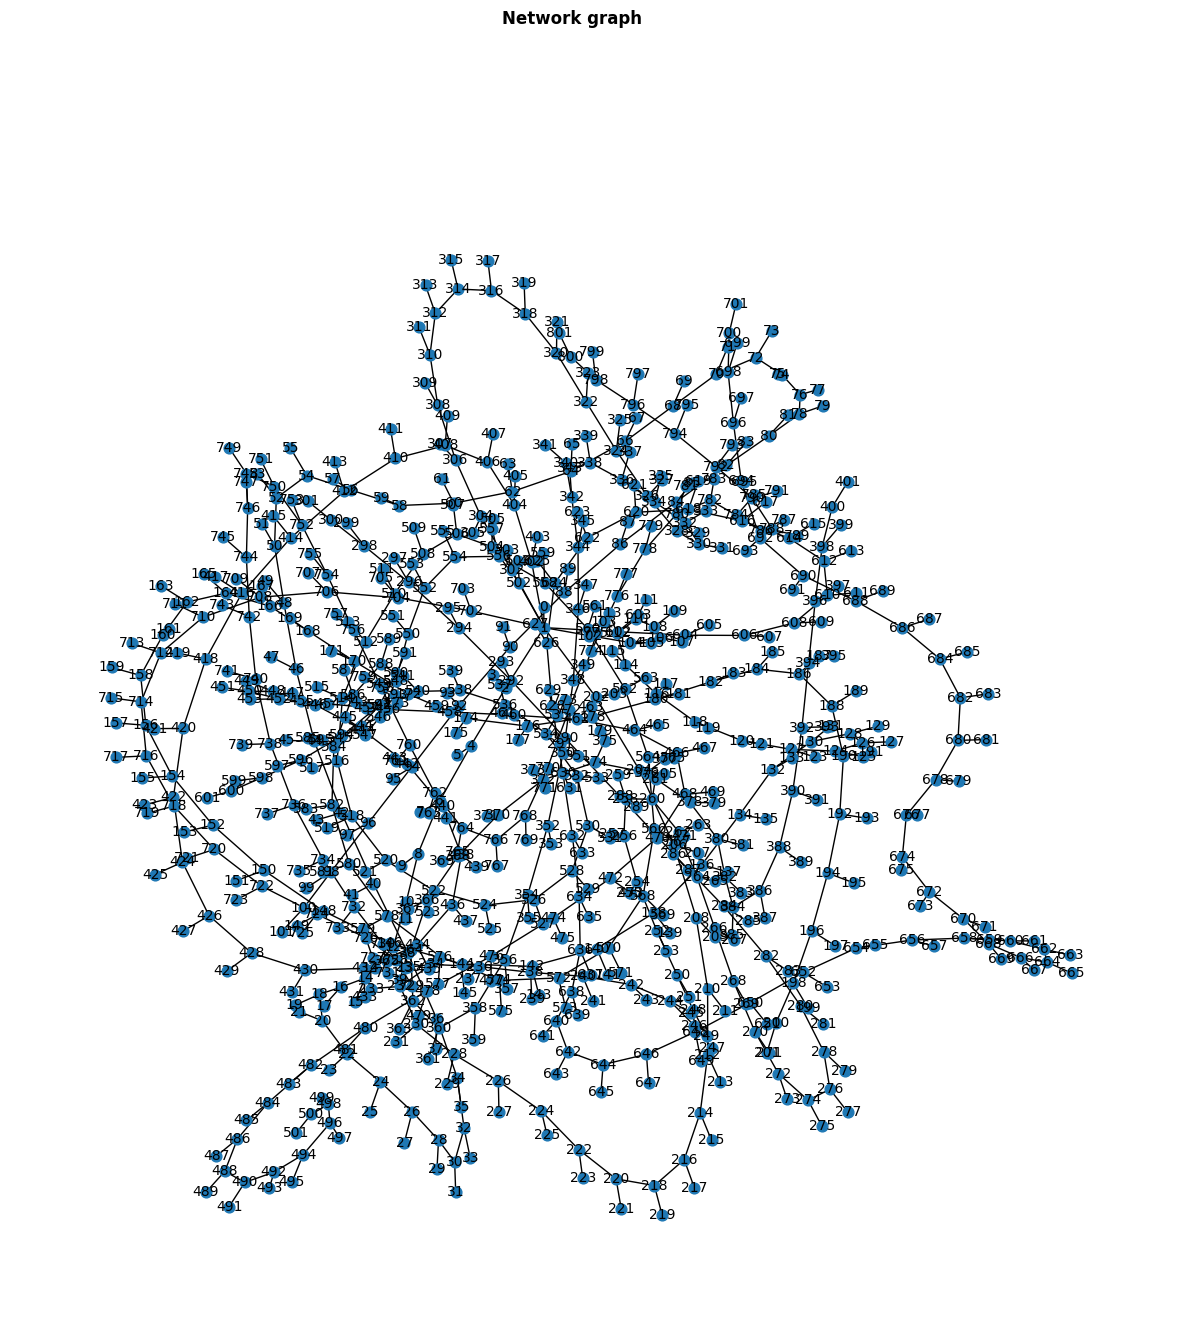

In [27]:
dataset = json_deserialize_from_file("input_network_data_big.json")
reactive_power_data = pd.read_parquet("reactive_power_profile_big.parquet")
active_power_data = pd.read_parquet("active_power_profile_big.parquet")
ev_active_power_data = pd.read_parquet("ev_active_power_profile_big.parquet")

psm = pss.PowerSim(grid_data=dataset)

psm.network_plotter()

Figure(1500x1500)


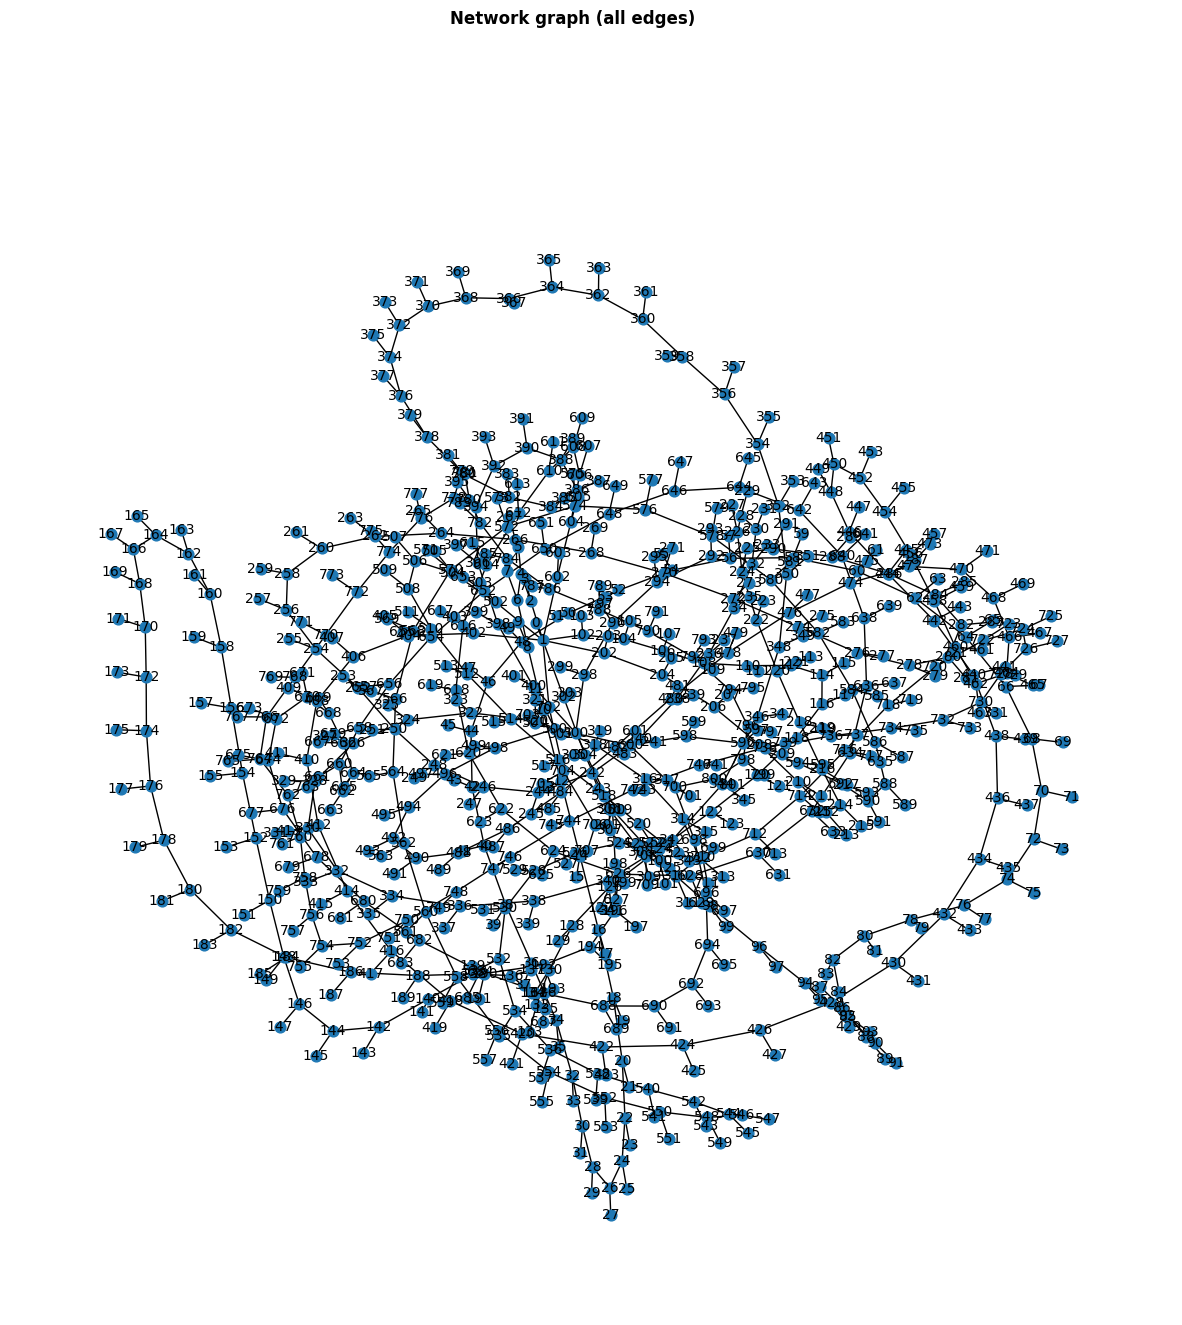

In [28]:
psm.network_plotter(plot_criteria=tp.AllEdges)

# Team collaboration

In the beginning of the project deadlines were set for all three assigments. For every assigment we have divided the tasks and everyone mainly worked on it alone and when help was needed other teammates assisted. 

We had meetings twice a week which helped a lot to keep each other up-to-date. 

Everyone worked on their own branch and when something was finished it was check by other group members and approved/or improved and afterwards approved. 


# Lessons learnt

Everyone did had limited experience with Python and Git, but this project we have learnt a lot about it. Now we feel a lot more comfortable with using Pylint, Isort and black. Commiting, making branches and push/pulling went very well in the team. Using the Github Desktop application also helped to understand everything. 

Sometimes it would have been benificial if we would have an 'official' meeting every week. Everyone was working well on their parts, but we were not up to date what the others were doing. 

After assignment 2 we were slightly behind schedule, but we were still confident that we could finish it all. This meant that we needed to do a little bit more on the final day, but we finished it all in the end.